In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sbn

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

from balancers import PredictionBalancer
import tools

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss, DemographicParity

from utils import *
from demv import DEMV
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

Protected groups : age = 0, sex = 0 

Positive label : credit = 1

In [2]:
data = pd.read_csv('data2/german.csv', index_col=0)

In [3]:
data

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,sex,status=A11,status=A12,...,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit
0,6.0,1169.0,4.0,4.0,1.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,48.0,5951.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,12.0,2096.0,2.0,3.0,1.0,1.0,2.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,42.0,7882.0,2.0,4.0,1.0,1.0,2.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,24.0,4870.0,3.0,4.0,1.0,2.0,2.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.0,1736.0,3.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
996,30.0,3857.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
997,12.0,804.0,4.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
998,45.0,1845.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [4]:
label = 'credit'
positive_label = 1
sensitive_features = ['sex', 'age']
unpriv_group = {'sex': 0, 'age': 0}

In [5]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression())
])

## Biased data

In [6]:
model, bias_metrics, y_pred = cross_val2(pipeline, data, label, unpriv_group, sensitive_features, positive_label=positive_label)

In [7]:
print_metrics(bias_metrics)

Statistical parity:  -0.201  +-  0.139
Disparate impact:  0.743  +-  0.164
Zero one loss:  0.317  +-  0.117
F1 score:  0.731  +-  0.045
Accuracy score:  0.741  +-  0.044


## DEMV

In [8]:
demv_data = data.copy()
demv = DEMV(round_level=1)

In [9]:
model, demv_metrics = cross_val(pipeline, demv_data, label, unpriv_group, sensitive_features, debiaser=demv, positive_label=positive_label)

In [10]:
print_metrics(demv_metrics)

Statistical parity:  -0.124  +-  0.158
Disparate impact:  0.806  +-  0.157
Zero one loss:  0.259  +-  0.129
F1 score:  0.739  +-  0.038
Accuracy score:  0.75  +-  0.035


## DEMV Evaluation

In [11]:
metrics = eval_demv(2, demv.get_iters(), data.copy(), pipeline, label, unpriv_group, sensitive_features, positive_label=positive_label)

## Post Processing

In [12]:
sensitive_features = ['combined']
unpriv_group = {'combined': 1}

In [13]:
from balancers import PredictionBalancer

data.loc[:,"combined"] = 0
data.loc[(data['sex'] == 0) & (data["age"] == 0),"combined"] = 1

a = data.combined.values

y_ = []
for list in y_pred:
    for j in list:
        y_.append(int(j))

y_ = np.array(y_)

y_ = np.array(y_ == 1.0 , dtype=np.uint8)

y = np.array(data.credit == 1.0, dtype=np.uint8)
y = np.array(y)


In [14]:
pb = PredictionBalancer(y=y, y_=y_, a=a)

y_adj = pb.adjust(summary = True)


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.7194 0.7819
   1.0 0.8298 0.7586

And loss is 0.3750


Post-adjustment group rates are 

 group  fpr    tpr
   0.0  1.0 0.9984
   1.0  1.0 0.9828

And loss is 0.3020



In [15]:
datapred = deepcopy(data)
datapred[label] = y_adj

blackboxmetrics = get_metrics( data, datapred , unpriv_group, label, positive_label   )

## Plot

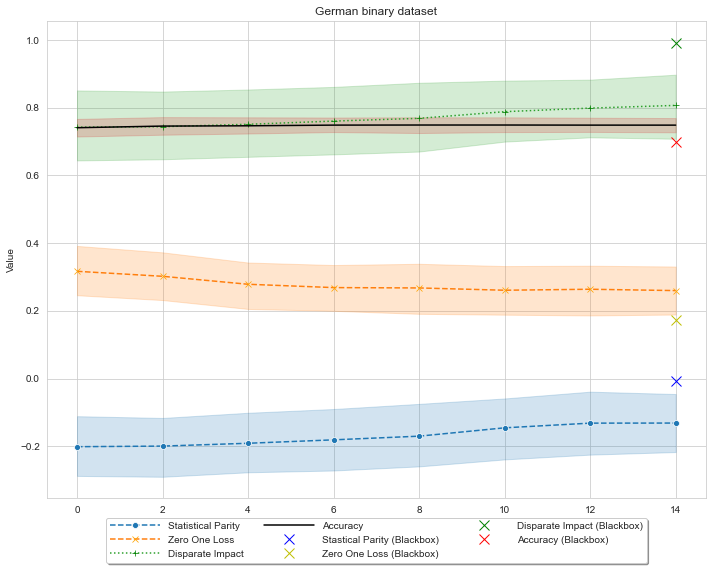

Dataset size: 1000
Unprivileged group size: 105
Percentage of unprivileged group: 10.5
Number of iterations: 14


In [16]:
df = prepareplots(metrics,'german')
points = preparepoints(blackboxmetrics,demv.get_iters())


plot_metrics_curves(df, points, 'German binary dataset')
unprivpergentage(data,unpriv_group, demv.get_iters())